In [1]:
# setup
import pathlib
base_dir = pathlib.Path("/Users/eyubogln/.meerkat/datasets/rfw/")

# Auditing Machine Learning Models with Meerkat 


In this demo, we’ll be using the Racial Faces in the Wild (RFW) dataset to audit AWS’s FaceCompare API. We provide predictions from the API on this dataset. Your task is to analyze model performance on this dataset and identify slices where the model is performing particularly poorly or particularly well.

In order to audit the API, we’ll be using a tool we’re developing that helps data scientists help wrangle and analyze unstructured data: it’s called [Meerkat](https://meerkat.readthedocs.io/en/latest/guide/guide.html). Under the hood, it uses techniques like those described in [Domino](https://meerkat.readthedocs.io/en/latest/guide/guide.html) to identifying underperforming populations in machine learning datasets.

So, let’s import the Python package and get started!

In [2]:
import meerkat as mk

## Loading Data

Meerkat provides a [registry](https://meerkat.readthedocs.io/en/dev/datasets/datasets.html) of commonly used datasets, like RFW, which allows us to load the data into memory with one line of code.  We can then merge the dataset with a CSV containing the model predictions. 

In memory, the dataset and model predictions are stored in a [Meerkat DataPanel](https://meerkat.readthedocs.io/en/latest/guide/data_structures.html). A `DataPanel` is in many ways just like a Pandas DataFrame: it’s a tabular data structure made up of columns. Unlike a DataFrame though, the `DataPanel` is designed for unstructured data types like images and audio. As you can see in the table visualization below, there’s a column for the image, the false non-match rate (FNMR), id etc.


,image_id (PandasSeriesColumn),identity (PandasSeriesColumn),ethnicity (PandasSeriesColumn),image (ImageColumn)
0,m.0cqh0q_0001,m.0cqh0q,caucasian,
1,m.0cqh0q_0003,m.0cqh0q,caucasian,
2,m.0cqh0q_0004,m.0cqh0q,caucasian,

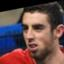
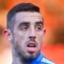
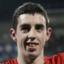

In [3]:
dp = mk.get("rfw")
dp.head(3)

**Loading CompareFaces Errors**. CompareFaces is an operation in Amazon Rekognition that predicts whether two images are taken of the same person. We've applied CompareFaces v6 (an AWS service) to the RFW dataset and stored the error rates for each image in the file `facecompare_v6_errors.csv`. Specifically, we've computed the *False Non-Match Rate* (FNMR) for each image, a measure of how often the model falsely predicts that two images are **not** of the same person.

<div>
<img src="fnmr.png" width="400"/>
</div>

We can load these error rates into our DataPanel with a single `DataPanel.merge` call which is equivalent to a `merge` in Pandas or a `join` in SQL. After doing this, we can see that the FNMR for each image is stored in the new `v6_fnmr` column.

,image_id (PandasSeriesColumn),identity (PandasSeriesColumn),ethnicity (PandasSeriesColumn),image (ImageColumn),v6_fnmr (PandasSeriesColumn)
0,m.0cqh0q_0001,m.0cqh0q,caucasian,,0.0
1,m.0cqh0q_0003,m.0cqh0q,caucasian,,0.0
2,m.0cqh0q_0004,m.0cqh0q,caucasian,,0.0

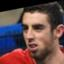
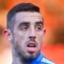
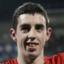

In [4]:
dp = dp.merge(
	mk.DataPanel.from_csv(base_dir / "themis/facecompare_v6_errors.csv"),
	on="image_id",
)
dp.head(3)

There are a number of operations that can be performed on a `DataPanel`, for example, we can use `sample` to randomly shuffle the dataset. 

In [5]:
dp = dp.sample(frac=1, replace=False)

## Exploring the Dataset

To help with explore datasets with unstructured data types (*e.g.* images), Meerkat allows you to spin up interactive GUIs from within your notebook. These visualizations allow you to efficiently explore large image, audio, and video datasets. 

Note that the visualizations are highly customizable. There are a few different interface types (*e.g.  “*gallery”, “table”, “plot”) that can be customized from within the notebook.  See the documentation for a full list of interfaces. 

First though, we'll have to execute the two cells below to launch the interactive mode. 

In [6]:
network, register_api = mk.interactive_mode()


> src@0.0.1 dev
> vite dev "--port" "7861"


  VITE v3.0.3  ready in 325 ms

  ➜  Local:   http://localhost:7861/
  ➜  Network: use --host to expose


In [7]:
register_api()

To begin, understanding the errors, we'll sort the DataPanel by the FNMR column and then launch a new interface. 

In [8]:
dp = dp.sort(by="v6_fnmr", ascending=False) 

dp.gui.table()

2:22:54 PM [vite-plugin-svelte] /Users/eyubogln/code/meerkat/meerkat/interactive/app/src/lib/TableView.svelte:164:1 Unused CSS selector ".dark .table-view"
2:22:54 PM [vite-plugin-svelte] /Users/eyubogln/code/meerkat/meerkat/interactive/app/src/lib/components/sliceby/SliceCard.svelte:9:11 SliceCard has unused export property 'datapanel_id'. If it is for external reference only, please consider using `export const datapanel_id`
2:22:54 PM [vite-plugin-svelte] /Users/eyubogln/code/meerkat/meerkat/interactive/app/src/lib/components/plot_header/PlotHeader.svelte:8:11 PlotHeader has unused export property 'rows_promise'. If it is for external reference only, please consider using `export const rows_promise`
2:22:54 PM [vite-plugin-svelte] /Users/eyubogln/code/meerkat/meerkat/interactive/app/src/lib/components/match_header/MatchHeader.svelte:104:1 Unused CSS selector ".list-container"
2:22:54 PM [vite-plugin-svelte] /Users/eyubogln/code/meerkat/meerkat/interactive/app/src/lib/components/tabl

## Computing global metrics
Next we’ll  compute some average metrics across the entire dataset to get a sense of how the model is performing globally.

In [9]:
global_fnmr = dp["v6_fnmr"].mean()
print(f"Global False Non-Match Rate: {global_fnmr: .2%}")

Global False Non-Match Rate:  2.29%


## Computing group statistics

RFW provides annotations for limited set of high-level racial groups. In ths section, we’ll see how performance varies when stratifying by these groups. To do so, we’ll use `mk.groupby`.

In [10]:
gb = dp.groupby("ethnicity")
gb["v6_fnmr"].mean()

,v6_fnmr (NumpyArrayColumn),ethnicity (PandasSeriesColumn)
0,0.011847,african
1,0.028929,asian
2,0.028373,caucasian
3,0.022819,indian


We can also visualize the groups in a `GroupBy` with the `cards` interface:

In [11]:
gb.gui.cards(
    main_column="image", 
    tag_columns=["v6_fnmr"],
    aggregations={
        "Mean FNMR": lambda x: x["v6_fnmr"].mean(),
        "STD FNMR": lambda x: x["v6_fnmr"].std(),
        "Size": len,
    }
)

In here.
http://127.0.0.1:7860
Response {
  [Symbol(realm)]: null,
  [Symbol(state)]: {
    aborted: false,
    rangeRequested: false,
    timingAllowPassed: true,
    requestIncludesCredentials: true,
    type: 'default',
    status: 200,
    timingInfo: {
      startTime: 6711.939916014671,
      redirectStartTime: 6711.939916014671,
      redirectEndTime: 6712.9994159936905,
      postRedirectStartTime: 6712.9994159936905,
      finalServiceWorkerStartTime: 0,
      finalNetworkResponseStartTime: 0,
      finalNetworkRequestStartTime: 0,
      endTime: 0,
      encodedBodySize: 0,
      decodedBodySize: 0,
      finalConnectionTimingInfo: null
    },
    cacheState: '',
    statusText: 'OK',
    headersList: HeadersList {
      [Symbol(headers map)]: [Map],
      [Symbol(headers map sorted)]: null
    },
    urlList: [ [URL], [URL] ],
    body: { stream: undefined }
  },
  [Symbol(headers)]: HeadersList {
    [Symbol(headers map)]: Map(4) {
      'date' => 'Thu, 18 Aug 2022 21:22:55

## Going beyond available metadata... 

The trouble is, the subgroup annotations provided in RFW are quite limited. What if there are other groups that we'd like to explore for which we lack annotations?

This is where things start to get interesting: we are goinng to use large, pretrained models in order to bootstrap our dataset with more metadata! This is the key idea behind Meerkat.

To demonstrate this idea, we've implemented the `match` operation in the GUI. With `match`, we can create new columns by writing natural language queries and matching them to the images. For example, say we want a metadata column that tells us whether the person in the image is wearing sunglasses. We can write a query like: "A person wearing sunglasses."

Let's try it out below. First, we'll need to `embed` the images into a latent space using a pretrained encoder (e.g. CLIP). Meerkat includes a registry of available encoders, so we can just specify one in the `mk.embed` call.

In [12]:
# In practice, columns can be embedded using `mk.embed`, however, for time's sake, we'll 
# just merge in the embeddings below
# dp = mk.embed(dp, input="image", num_workers=0, encoder="clip", device=0)

dp = dp.merge(
    mk.DataPanel.read(base_dir / "main/rfw_embedded.mk")["image_id", "clip(image)"],
    on="image_id"
)

In [13]:
dp.gui.table()

In here.
http://127.0.0.1:7860
Response {
  [Symbol(realm)]: null,
  [Symbol(state)]: {
    aborted: false,
    rangeRequested: false,
    timingAllowPassed: true,
    requestIncludesCredentials: true,
    type: 'default',
    status: 200,
    timingInfo: {
      startTime: 9582.516708016396,
      redirectStartTime: 9582.516708016396,
      redirectEndTime: 9583.367250084877,
      postRedirectStartTime: 9583.367250084877,
      finalServiceWorkerStartTime: 0,
      finalNetworkResponseStartTime: 0,
      finalNetworkRequestStartTime: 0,
      endTime: 0,
      encodedBodySize: 0,
      decodedBodySize: 0,
      finalConnectionTimingInfo: null
    },
    cacheState: '',
    statusText: 'OK',
    headersList: HeadersList {
      [Symbol(headers map)]: [Map],
      [Symbol(headers map sorted)]: null
    },
    urlList: [ [URL], [URL] ],
    body: { stream: undefined }
  },
  [Symbol(headers)]: HeadersList {
    [Symbol(headers map)]: Map(4) {
      'date' => 'Thu, 18 Aug 2022 21:22:55 G

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Matching produces a continuous score for each image in the dataset. We'd like to find a *threshold score* above which people are wearing sunglasses. Using the gallery view we can find this threshold quite easily. 

In [14]:
dp["sunglasses"] = dp["_match_image_A person wearing sunglasses."] - dp["_match_image_A person."]
dp = dp.sort(by="sunglasses", ascending=False)
dp.gui.table()

In here.
http://127.0.0.1:7860
Response {
  [Symbol(realm)]: null,
  [Symbol(state)]: {
    aborted: false,
    rangeRequested: false,
    timingAllowPassed: true,
    requestIncludesCredentials: true,
    type: 'default',
    status: 200,
    timingInfo: {
      startTime: 40864.37191605568,
      redirectStartTime: 40864.37191605568,
      redirectEndTime: 40865.6775829792,
      postRedirectStartTime: 40865.6775829792,
      finalServiceWorkerStartTime: 0,
      finalNetworkResponseStartTime: 0,
      finalNetworkRequestStartTime: 0,
      endTime: 0,
      encodedBodySize: 0,
      decodedBodySize: 0,
      finalConnectionTimingInfo: null
    },
    cacheState: '',
    statusText: 'OK',
    headersList: HeadersList {
      [Symbol(headers map)]: [Map],
      [Symbol(headers map sorted)]: null
    },
    urlList: [ [URL], [URL] ],
    body: { stream: undefined }
  },
  [Symbol(headers)]: HeadersList {
    [Symbol(headers map)]: Map(4) {
      'date' => 'Thu, 18 Aug 2022 21:23:33 GMT

In [15]:
dp["sunglasses"] = dp["sunglasses"] > -0.23

In [16]:
dp = dp.sample(frac=1, replace=False)

In [17]:
gb = dp.groupby(by="sunglasses")
gb["v6_fnmr"].mean()


,v6_fnmr (NumpyArrayColumn),sunglasses (NumpyArrayColumn)
0,0.022541,False
1,0.038014,True


In [18]:
gb.gui.cards(
    main_column="image", 
    tag_columns=["v6_fnmr"],
    aggregations={
        "Mean FNMR": lambda x: x["v6_fnmr"].mean(),
        "STD FNMR": lambda x: x["v6_fnmr"].std(),
        "Size": len,
    }
)

In here.
http://127.0.0.1:7860
Response {
  [Symbol(realm)]: null,
  [Symbol(state)]: {
    aborted: false,
    rangeRequested: false,
    timingAllowPassed: true,
    requestIncludesCredentials: true,
    type: 'default',
    status: 200,
    timingInfo: {
      startTime: 125846.68587505817,
      redirectStartTime: 125846.68587505817,
      redirectEndTime: 125848.81166601181,
      postRedirectStartTime: 125848.81166601181,
      finalServiceWorkerStartTime: 0,
      finalNetworkResponseStartTime: 0,
      finalNetworkRequestStartTime: 0,
      endTime: 0,
      encodedBodySize: 0,
      decodedBodySize: 0,
      finalConnectionTimingInfo: null
    },
    cacheState: '',
    statusText: 'OK',
    headersList: HeadersList {
      [Symbol(headers map)]: [Map],
      [Symbol(headers map sorted)]: null
    },
    urlList: [ [URL], [URL] ],
    body: { stream: undefined }
  },
  [Symbol(headers)]: HeadersList {
    [Symbol(headers map)]: Map(4) {
      'date' => 'Thu, 18 Aug 2022 21:24:

In [ ]:
dp.gui.table()

## Discovering slices

The subgroup annotations provided in RFW are quite limited, so we’ll use meerkat to *discover* new slices. To do so, we’ll use `dp.explainby`, a method that identifies a set of slices (*i.e.* scalar functions of the `by` column) that explain the variance in the response variable.



In [19]:
from meerkat.ops.sliceby.explainby import explainby

# dp = mk.DataPanel.read(base_dir / "themis/facecompare_v6_global_slices.mk")

indian_dp = dp.lz[dp["ethnicity"] == "indian"] 

eb = explainby(indian_dp, by="image", target="v6_fnmr",  n_slices=10, use_cache=True)

  0%|          | 0/100 [00:00<?, ?it/s]

In [20]:
eb.gui.cards(
    main_column="image", 
    tag_columns=["v6_fnmr", "ethnicity"],
    aggregations={
        "Mean FNMR": lambda x: x["v6_fnmr"].mean(),
        "STD FNMR": lambda x: x["v6_fnmr"].std(),
        "Size": len,
    }
)

In here.
http://127.0.0.1:7860
Response {
  [Symbol(realm)]: null,
  [Symbol(state)]: {
    aborted: false,
    rangeRequested: false,
    timingAllowPassed: true,
    requestIncludesCredentials: true,
    type: 'default',
    status: 200,
    timingInfo: {
      startTime: 182679.6961660385,
      redirectStartTime: 182679.6961660385,
      redirectEndTime: 182681.21908307076,
      postRedirectStartTime: 182681.21908307076,
      finalServiceWorkerStartTime: 0,
      finalNetworkResponseStartTime: 0,
      finalNetworkRequestStartTime: 0,
      endTime: 0,
      encodedBodySize: 0,
      decodedBodySize: 0,
      finalConnectionTimingInfo: null
    },
    cacheState: '',
    statusText: 'OK',
    headersList: HeadersList {
      [Symbol(headers map)]: [Map],
      [Symbol(headers map sorted)]: null
    },
    urlList: [ [URL], [URL] ],
    body: { stream: undefined }
  },
  [Symbol(headers)]: HeadersList {
    [Symbol(headers map)]: Map(4) {
      'date' => 'Thu, 18 Aug 2022 21:25:54

In [ ]:
indian_dp = indian_dp.sort(by="v6_fnmr", ascending=False)
cb = indian_dp.clusterby(by="image")
cb.gui.cards(
    main_column="image", 
    tag_columns=["v6_fnmr", "ethnicity"],
    aggregations={
        "Mean FNMR": lambda x: x["v6_fnmr"].mean(),
        "STD FNMR": lambda x: x["v6_fnmr"].std(),
        "Size": len,
    }
)

## Diving deeper

In practice, the slices discovered in the previous section should serve as inspiration for further exploration. One great way to quickly continue exploring other slices is via the plot interface. Unlike standard plotting interfaces, you can actually manipulate the axes and add labels for columns that don’t yet exist.

In [21]:
indian_dp.gui.table()

In here.
http://127.0.0.1:7860
Response {
  [Symbol(realm)]: null,
  [Symbol(state)]: {
    aborted: false,
    rangeRequested: false,
    timingAllowPassed: true,
    requestIncludesCredentials: true,
    type: 'default',
    status: 200,
    timingInfo: {
      startTime: 240731.8119159937,
      redirectStartTime: 240731.8119159937,
      redirectEndTime: 240733.22329103947,
      postRedirectStartTime: 240733.22329103947,
      finalServiceWorkerStartTime: 0,
      finalNetworkResponseStartTime: 0,
      finalNetworkRequestStartTime: 0,
      endTime: 0,
      encodedBodySize: 0,
      decodedBodySize: 0,
      finalConnectionTimingInfo: null
    },
    cacheState: '',
    statusText: 'OK',
    headersList: HeadersList {
      [Symbol(headers map)]: [Map],
      [Symbol(headers map sorted)]: null
    },
    urlList: [ [URL], [URL] ],
    body: { stream: undefined }
  },
  [Symbol(headers)]: HeadersList {
    [Symbol(headers map)]: Map(4) {
      'date' => 'Thu, 18 Aug 2022 21:26:52

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
slice_idx = 0
indian_dp[f"slice_{slice_idx}"] = indian_dp["MixtureSlicer(image,v6_fnmr)"][:, slice_idx]

**Demo goals.** The purpose of this demo is to collect feedback on the tools we’re developing. We would like to understand how they can be made more useful for the task of auditing machine learning models. We are still in very early days, so your concerns/suggestions will inform how we move forward. So, please be candid – any and all feedback is appreciated. To help guide the discussion, we’ve included below some specific questions that are particularly front-of-mind for us, but feel free to diverge from these topics:

❓ **Questions to Guide Feedback.**

*Did you learn something new about the behavior of this algorithm? Did you find slices that you would flag for bias concerns?* 

*Are these slices actionable? What would that action be? How would you address this slice?* 

*Did the slices you found seem important/interesting to you? If not, what kinds of slices do you think would be important to find?* *Why do you supect it is hard to find those slices?* 

Interface Questions

- *Did you find the natural language descriptions useful for describing discovered slices, or did just looking through the pictures suffice? Did you trust the descriptions? Concrete examples (ideally with screenshots) would be great here.*
- *Did you use natural language to test out new slices? What types of prompts did you write? Did you trust the results?*
- *The main interface we currently provide for creating new slices is with natural language? Are there other interfaces you would find useful (*e.g. *scribbling, cropping, upload images)? Were there slices you would’ve liked to test, but weren’t able to?*
- *Did you trust the statistics computed on the slices? How can we improve trust? *

Implementation Questions:

- *For the types of datasets you work with, do you think it would be easy to store it in a Meerkat DataPanel? Does this data structure feel like a good fit? How could it be improved to better support your data?*
- *Are there views, plots, visualizations of the data that you were craving?*
- *Was it easy to use Meerkat in a Jupyter Notebook?*

